<a href="https://colab.research.google.com/github/ayush9818/brain-tumour-detection/blob/main/Brain_Tumor_Classification_Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import cv2
import os
import numpy as np
from tqdm import tqdm
import time
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils

In [3]:
df = pd.read_csv('/content/drive/MyDrive/brain_tumor_dataset/df.csv')
train_df = df[df['type']=='train']
print(train_df.shape)

valid_df = df[df['type']=='valid']
print(valid_df.shape)

(1494, 5)
(262, 5)


In [4]:
IMG_HEIGHT, IMG_WIDTH  = (224,224)

In [5]:
def crop_brain_contour(image):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return new_image            

In [6]:
def load_data(df, img_height, img_width):
  X = []
  y = []
  for idx,sample in df.iterrows():
    image_path = sample['image_path']
    image = cv2.imread(image_path)
    image = crop_brain_contour(image)
    image = cv2.resize(image, dsize=(img_width, img_height), interpolation=cv2.INTER_CUBIC)
    image = image / 255.
    X.append(image)
    if sample['label'] == "yes":
      y.append(1)
    else:
      y.append(0)
  return np.array(X), np.array(y)

In [7]:
X_train, y_train = load_data(train_df, IMG_HEIGHT, IMG_WIDTH)
print("Shape of X_train : {}".format(X_train.shape))
print("Shape of y_train : {}".format(y_train.shape))

Shape of X_train : (1494, 224, 224, 3)
Shape of y_train : (1494,)


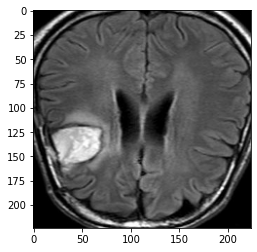

In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [9]:
X_val, y_val = load_data(valid_df, IMG_HEIGHT, IMG_WIDTH)
print("Shape of X_val : {}".format(X_val.shape))
print("Shape of y_val : {}".format(y_val.shape))

Shape of X_val : (262, 224, 224, 3)
Shape of y_val : (262,)


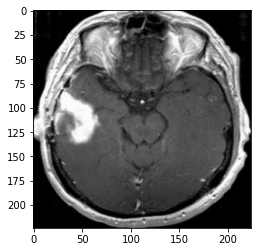

In [10]:
plt.imshow(X_val[0])

In [12]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Dense, Conv2D, Dropout, BatchNormalization
from tensorflow.python.keras.layers import MaxPooling2D, Input, Activation
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
#from tensorflow.python.keras.optimizers import adam
from tensorflow.python.keras.applications.resnet import ResNet101
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint,History,EarlyStopping
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.densenet import DenseNet121
import tensorflow as t
import numpy as np
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.models import load_model

In [13]:
def get_model():
  baseModel =  DenseNet121(weights="imagenet", include_top=False,pooling = 'avg',input_shape = (224,224,3))
  output = baseModel.output
  output = BatchNormalization()(output)
  output = Dense(128, activation='relu')(output)
  output = Dropout(0.2)(output)
  output = BatchNormalization()(output)
  output = Dense(1, activation='sigmoid')(output)
  model = Model(inputs=baseModel.input, outputs=output)

  for layer in baseModel.layers[:313]:
      layer.trainable = False
  for layer in baseModel.layers[313:]:
      layer.trainable = True
  return model

In [24]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [25]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
filepath="/content/drive/MyDrive/brain_tumor_dataset/models/model-preprocessed-densenet-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=5, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint,es,lr_reduce])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/50
47/47 [==============================] - 278s 6s/step - loss: 0.3265 - accuracy: 0.8545 - val_loss: 0.1360 - val_accuracy: 0.9351

Epoch 00001: val_accuracy improved from -inf to 0.93511, saving model to /content/drive/MyDrive/brain_tumor_dataset/models/model-preprocessed-densenet-01-0.94.hdf5
Epoch 2/50
47/47 [==============================] - 273s 6s/step - loss: 0.0346 - accuracy: 0.9933 - val_loss: 0.0349 - val_accuracy: 0.9885

Epoch 00002: val_accuracy improved from 0.93511 to 0.98855, saving model to /content/drive/MyDrive/brain_tumor_dataset/models/model-preprocessed-densenet-02-0.99.hdf5
Epoch 3/50
47/47 [==============================] - 270s 6s/step - loss: 0.0165 - accuracy: 0.9939 - val_loss: 0.0076 - val_accuracy: 1.0000

Epoch 00003: val_accuracy improved from 0.98855 to 1.00000, saving model to /content/drive/MyDrive/brain_tumor_dataset/models/model-preprocessed-densenet-03-1.00.hdf5
Epoch 4/50
47/47 [==============================] - 276s 6s/step - loss: 0.0

KeyboardInterrupt: ignored

In [30]:
history = model.history.history
for key in history.keys():
  print(key)

loss
accuracy
val_loss
val_accuracy
lr


In [31]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

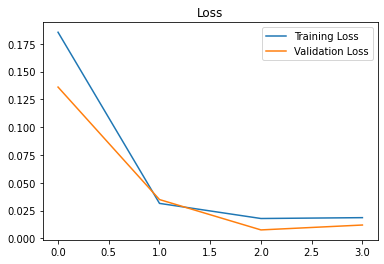

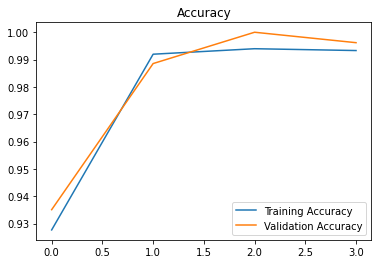

In [32]:
plot_metrics(history)

In [34]:
test_df = df[df['type']=='test']
# test_df.head()
X_test, y_test = load_data(test_df, IMG_HEIGHT, IMG_WIDTH)
print(X_test.shape)
print(y_test.shape)

(308, 224, 224, 3)
(308,)


In [35]:
final_model = load_model('/content/drive/MyDrive/brain_tumor_dataset/models/model-preprocessed-densenet-03-1.00.hdf5')
print("model loaded")

model loaded


In [36]:
loss, accuracy = final_model.evaluate(X_test, y_test)

10/10 [==============================] - 43s 4s/step - loss: 0.0209 - accuracy: 0.9935


In [37]:
y_pred = final_model.predict(X_test)

for i in range(y_pred.shape[0]):
  if y_pred[i]>=0.5:
    y_pred[i]=1
  else:
    y_pred[i]=0

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[144,   2],
       [  0, 162]])

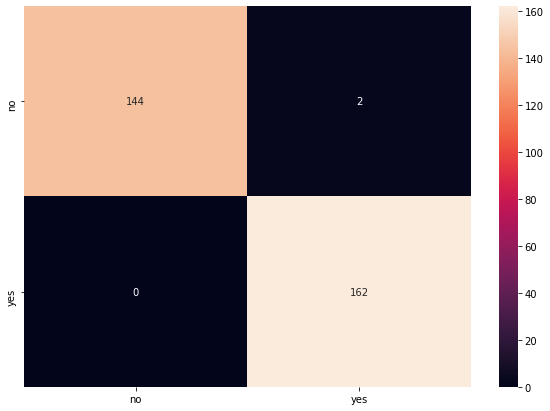

In [39]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index = ['no', 'yes'],
                  columns = ["no","yes"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       146
           1       0.99      1.00      0.99       162

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308

